# XNLI

### Graph 2-D plots with lang2vec score vs similarity to English


Saved plot to: ../graphs/xnli/language_similarity/timestamp\Consistency_vs_similarity_syntax_lang2vec.pdf


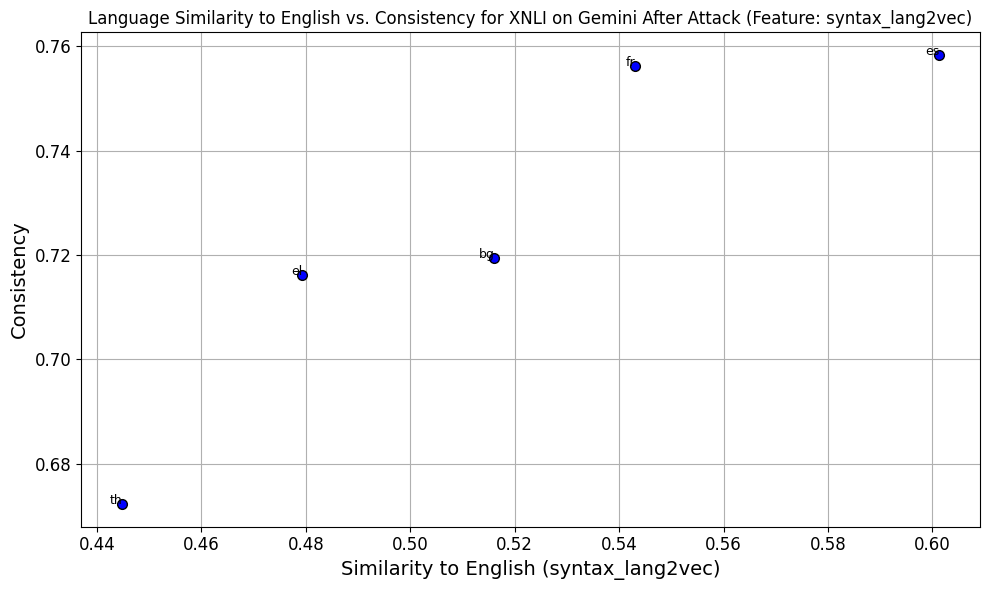

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

# ISO 639-1 to ISO 639-3 mapping
iso2_to_iso3 = {
    'en': 'eng', 'el': 'ell', 'bg': 'bul', 'es': 'spa',
    'fr': 'fra', 'th': 'tha', 'ar': 'ara', 'zh': 'zho',
    'ru': 'rus', 'tr': 'tur'
}

# Load accuracy data
accuracy_df = pd.read_csv("../xnli/analysis/20250528_194821/summary.txt", sep="\t")
accuracy_df = accuracy_df.rename(columns={'Language': 'language'})
accuracy_df['iso3'] = accuracy_df['language'].map(iso2_to_iso3)

# ---------- USER SELECTION ----------
selected_metric = 'Accuracy'              # Choose metric: 'Accuracy', 'Consistency', 'Entropy'.
if selected_metric != 'Accuracy':
    selected_metric_variance = None
else:
    selected_metric_variance = 'LabelVariance'  # Optional: set to None if no error bars needed

# Option A (False): Use generated similarity files which use cosine similarity
# Option B (True): Use precomputed distance CSVs from Lang2Vec GitHub (need to download the file from 
# the repository: https://github.com/antonisa/lang2vec, unzip it and add it in Pipeline/data/language_similarity/lang2vec)
use_precomputed = True
# ------------------------------------

if use_precomputed:
    distance_files = {
        'syntax_lang2vec': '../../data/language_similarity/lang2vec/distances/SYNTACTIC.csv',
        'phonology_lang2vec': '../../data/language_similarity/lang2vec/distances/PHONOLOGICAL.csv',
        'inventory_lang2vec': '../../data/language_similarity/lang2vec/distances/INVENTORY.csv',
        'geographic_lang2vec': '../../data/language_similarity/lang2vec/distances/GEOGRAPHIC.csv',
        'genetic_lang2vec': '../../data/language_similarity/lang2vec/distances/GENETIC.csv',
        'featural_lang2vec': '../../data/language_similarity/lang2vec/distances/FEATURAL.csv',
    }
else:
    distance_files = {
        'syntax_average': '../../data/language_similarity/lang2vec/syntax_average/language_similarity.csv',
        'phonology_average': '../../data/language_similarity/lang2vec/phonology_average/language_similarity.csv',
    }

# Loop through features
for feature, file_path in distance_files.items():

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    if use_precomputed:
        # Read matrix and convert to long-form
        df_wide = pd.read_csv(file_path)
        df_wide = df_wide.rename(columns={df_wide.columns[0]: 'lang1'})
        df_long = df_wide.melt(id_vars='lang1', var_name='lang2', value_name='distance')

        # Filter for English and normalize to similarity
        eng_df = df_long[
            (df_long['lang1'] == 'eng') & (df_long['lang2'] != 'eng')
            ].copy()

        eng_df['similarity'] = 1.0 - eng_df['distance']
        eng_df['iso3'] = eng_df['lang2']

    else:
        df = pd.read_csv(file_path)
        df = df.rename(columns={'language_1': 'lang1', 'language_2': 'lang2'})
        eng_df = df[
            ((df['lang1'] == 'eng') & (df['lang2'] != 'eng')) |
            ((df['lang2'] == 'eng') & (df['lang1'] != 'eng'))
            ].copy()
        eng_df['iso3'] = eng_df.apply(
            lambda row: row['lang2'] if row['lang1'] == 'eng' else row['lang1'],
            axis=1
        )
        eng_df['similarity'] = eng_df['similarity']  # already similarity

    # Merge and plot
    merged_df = eng_df.merge(accuracy_df, on='iso3')

    plt.figure(figsize=(10, 6))
    plt.errorbar(
        merged_df['similarity'],
        merged_df[selected_metric],
        yerr=merged_df[selected_metric_variance] if selected_metric_variance else None,
        fmt='o',
        ecolor='gray' if selected_metric_variance else None,
        capsize=5 if selected_metric_variance else 0,
        markerfacecolor='blue',
        markeredgecolor='black',
        markersize=7
    )

    for _, row in merged_df.iterrows():
        plt.text(row['similarity'], row[selected_metric], row['language'], fontsize=9, ha='right')

    plt.xlabel(f"Similarity to English ({feature})", fontsize=14)
    plt.ylabel(selected_metric, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f"Language Similarity to English vs. {selected_metric} for XNLI on Gemini (Feature: {feature})")
    plt.grid(True)
    plt.tight_layout()

    # Save figure as PDF
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"../graphs/xnli/language_similarity/{timestamp}"
    output_dir = "../graphs/xnli/language_similarity/timestamp"
    os.makedirs(output_dir, exist_ok=True)

    filename = f"{selected_metric}_vs_similarity_{feature}.pdf"
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, format='pdf')
    print(f"Saved plot to: {output_path}")

    plt.show()



# XQUAD
### Graph 2-D plots with lang2vec score vs similarity to English

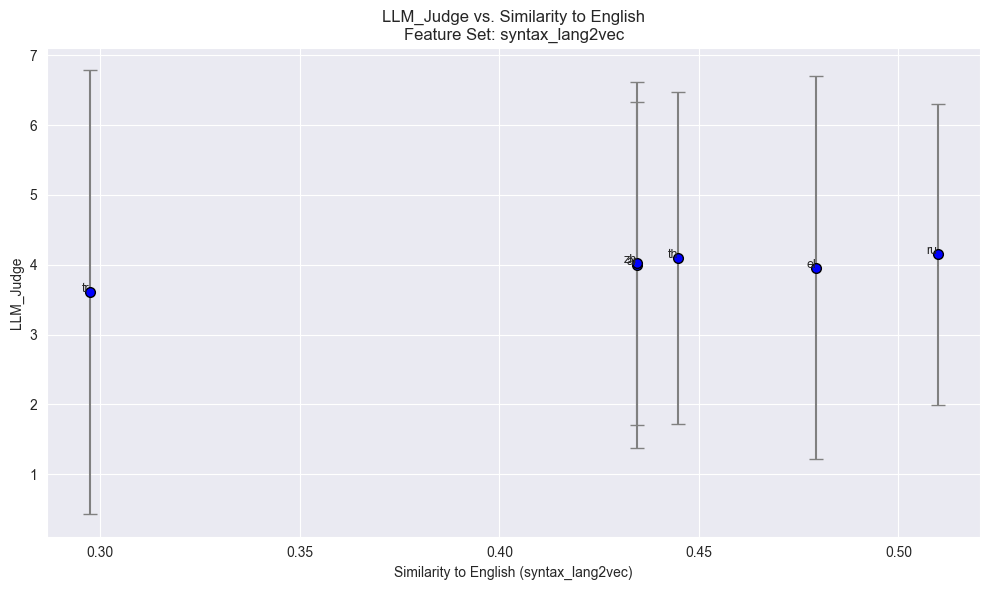

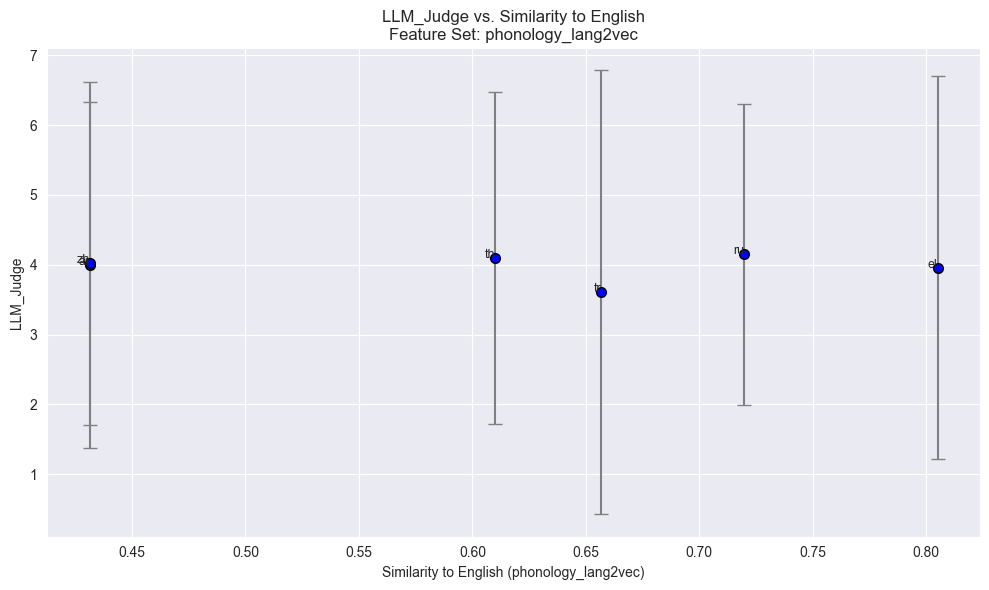

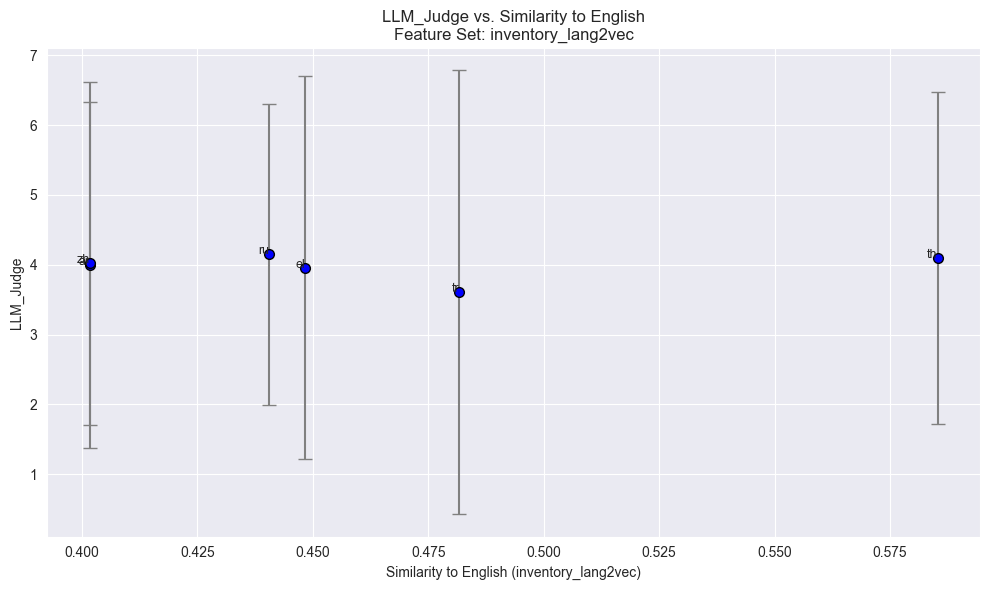

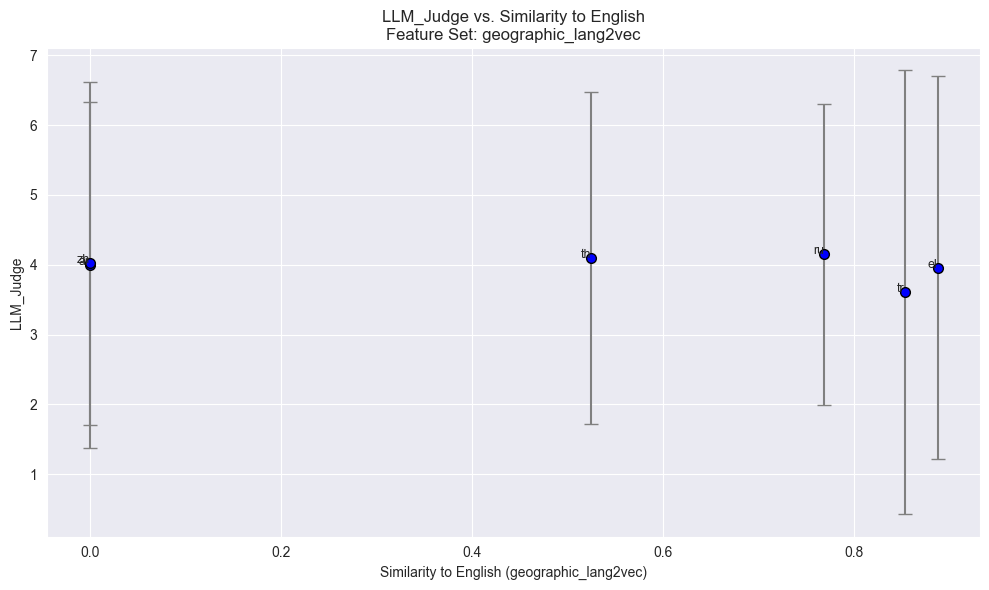

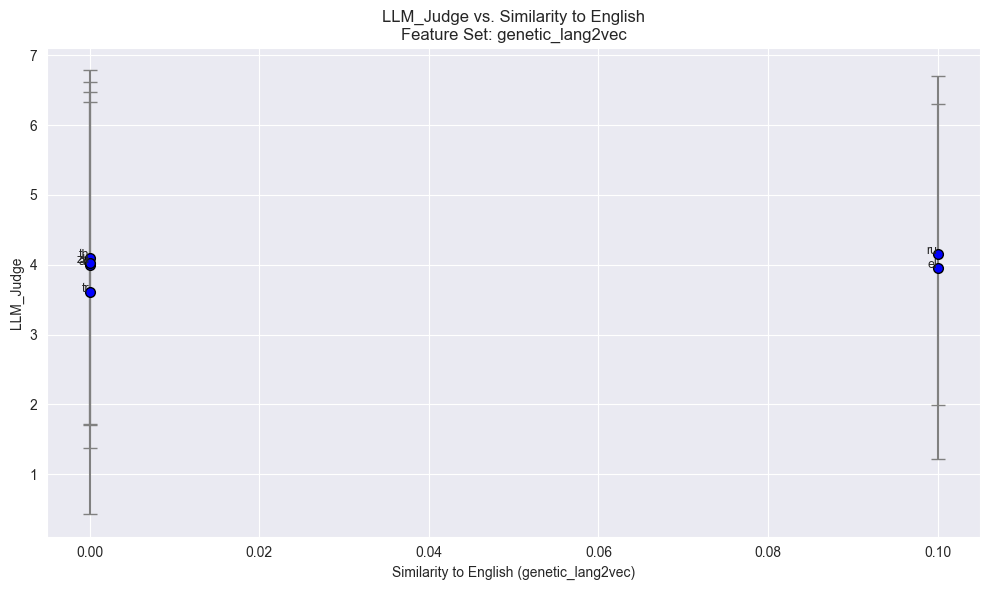

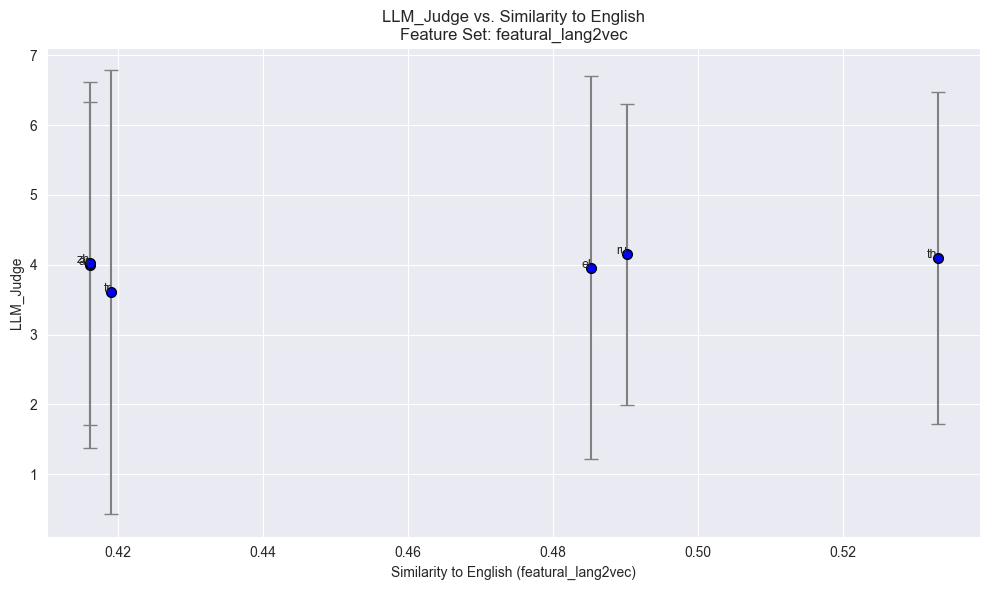

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ISO 639-1 to ISO 639-3 mapping
iso2_to_iso3 = {
    'en': 'eng', 'el': 'ell', 'bg': 'bul', 'es': 'spa',
    'fr': 'fra', 'th': 'tha', 'ar': 'ara', 'zh': 'zho', 'ru': 'rus', 'tr': 'tur'
}
iso3_to_iso2 = {v: k for k, v in iso2_to_iso3.items()}

# Load language evaluation metrics
metrics_df = pd.read_csv("../xquad/analysis/metrics_summary_20250423_151200.csv")
metrics_df['iso3'] = metrics_df['Language'].map(iso2_to_iso3)

# Option A (False): Use generated similarity files which use cosine similarity
# Option B (True): Use precomputed distance CSVs from Lang2Vec GitHub (need to download the file from 
# the repository: https://github.com/antonisa/lang2vec, unzip it and add it in Pipeline/data/language_similarity/lang2vec)
use_precomputed = True

if use_precomputed:
    distance_files = {
        'syntax_lang2vec': '../../data/language_similarity/lang2vec/distances/SYNTACTIC.csv',
        'phonology_lang2vec': '../../data/language_similarity/lang2vec/distances/PHONOLOGICAL.csv',
        'inventory_lang2vec': '../../data/language_similarity/lang2vec/distances/INVENTORY.csv',
        'geographic_lang2vec': '../../data/language_similarity/lang2vec/distances/GEOGRAPHIC.csv',
        'genetic_lang2vec': '../../data/language_similarity/lang2vec/distances/GENETIC.csv',
        'featural_lang2vec': '../../data/language_similarity/lang2vec/distances/FEATURAL.csv',
    }
else:
    distance_files = {
        'syntax_average': '../../data/language_similarity/lang2vec/syntax_average/language_similarity.csv',
        'phonology_average': '../../data/language_similarity/lang2vec/phonology_average/language_similarity.csv',
    }

# Evaluation metrics and variance columns
metrics = [
    # ('BLEU_Mean', 'BLEU_Var'),
    # ('METEOR_Mean', 'METEOR_Var'),
    # ('Cosine_Mean', 'Cosine_Var'),
    ('LLM_Judge_Mean', 'LLM_Judge_Var'),
]

# Loop through each feature set
for feature, file_path in distance_files.items():
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    if use_precomputed:
        df_wide = pd.read_csv(file_path)
        df_wide = df_wide.rename(columns={df_wide.columns[0]: 'lang1'})
        df_long = df_wide.melt(id_vars='lang1', var_name='lang2', value_name='distance')

        # Filter where lang1 is English only
        eng_df = df_long[(df_long['lang1'] == 'eng') & (df_long['lang2'] != 'eng')].copy()
        eng_df['similarity'] = 1.0 - eng_df['distance']
        eng_df['iso3'] = eng_df['lang2']
    else:
        df = pd.read_csv(file_path)
        df = df.rename(columns={'language_1': 'lang1', 'language_2': 'lang2'})
        eng_df = df[
            ((df['lang1'] == 'eng') & (df['lang2'] != 'eng')) |
            ((df['lang2'] == 'eng') & (df['lang1'] != 'eng'))
            ].copy()
        eng_df['iso3'] = eng_df.apply(
            lambda row: row['lang2'] if row['lang1'] == 'eng' else row['lang1'],
            axis=1
        )
        eng_df['Language'] = eng_df['iso3'].map(iso3_to_iso2)
        eng_df['similarity'] = eng_df['similarity']  # already similarity

    merged_df = eng_df.merge(metrics_df, on='iso3')
    merged_df['Language'] = merged_df['iso3'].map(iso3_to_iso2)

    for mean_col, var_col in metrics:
        plt.figure(figsize=(10, 6))

        plt.errorbar(
            merged_df['similarity'],
            merged_df[mean_col],
            yerr=merged_df[var_col],
            fmt='o',
            ecolor='gray',
            capsize=5,
            markerfacecolor='blue',
            markeredgecolor='black',
            markersize=7
        )

        for _, row in merged_df.iterrows():
            plt.text(row['similarity'], row[mean_col], row['Language'], fontsize=9, ha='right')

        plt.xlabel(f'Similarity to English ({feature})')
        plt.ylabel(mean_col.replace('_Mean', ''))
        plt.title(f'{mean_col.replace("_Mean", "")} vs. Similarity to English\nFeature Set: {feature}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Europa_random_split
### Graph 2-D plots with lang2vec score vs similarity to English

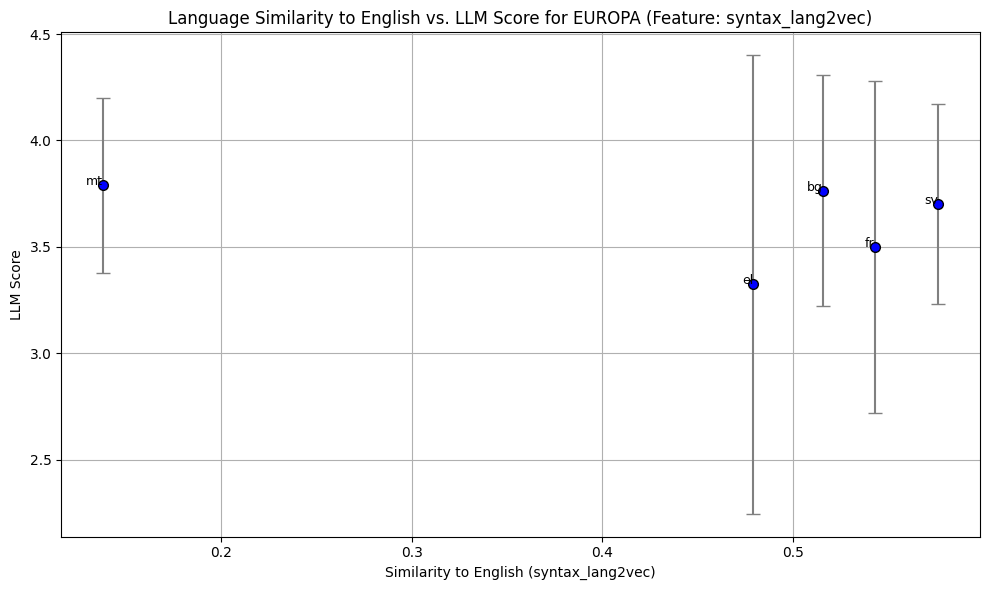

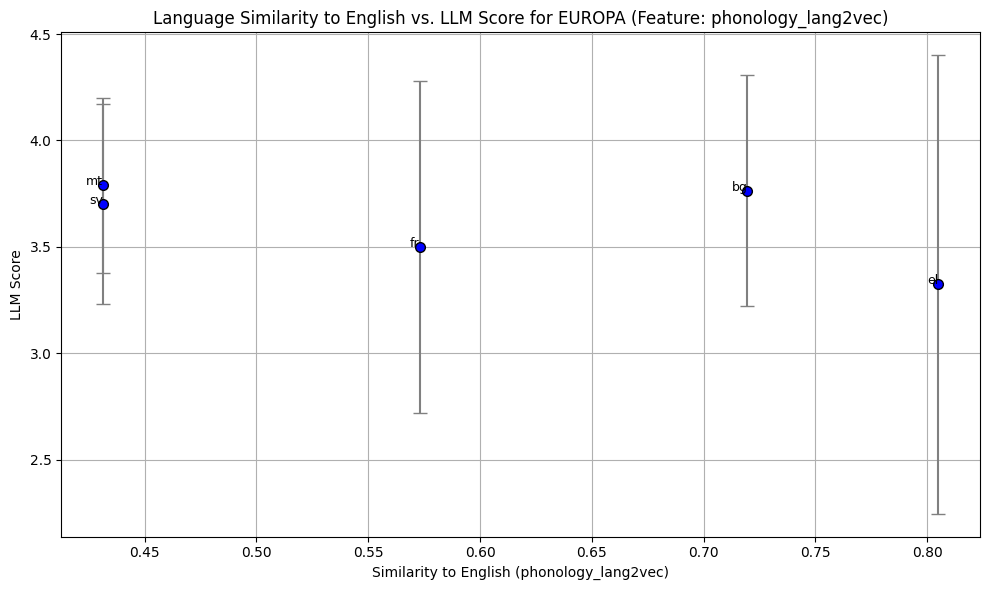

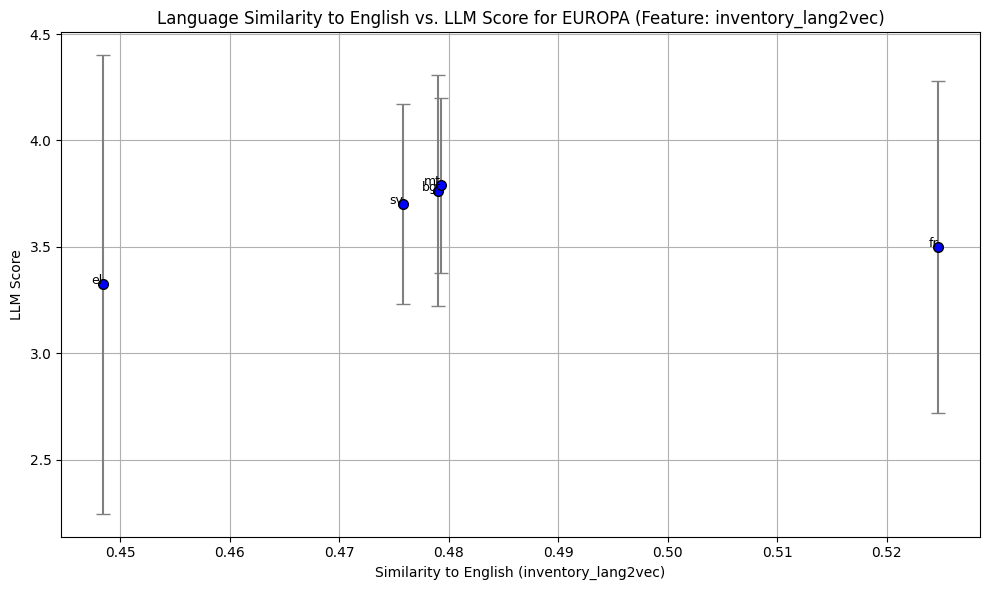

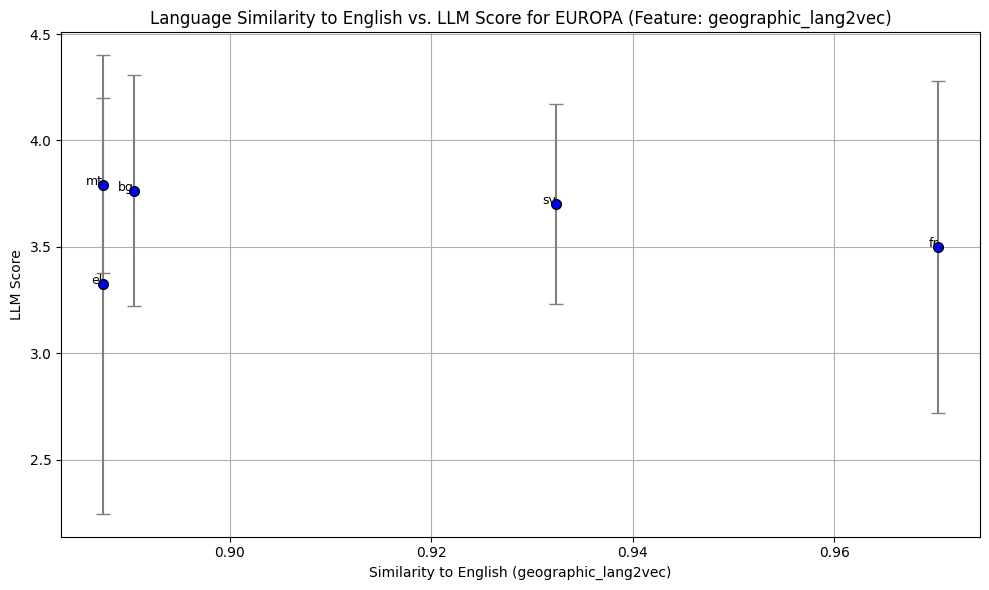

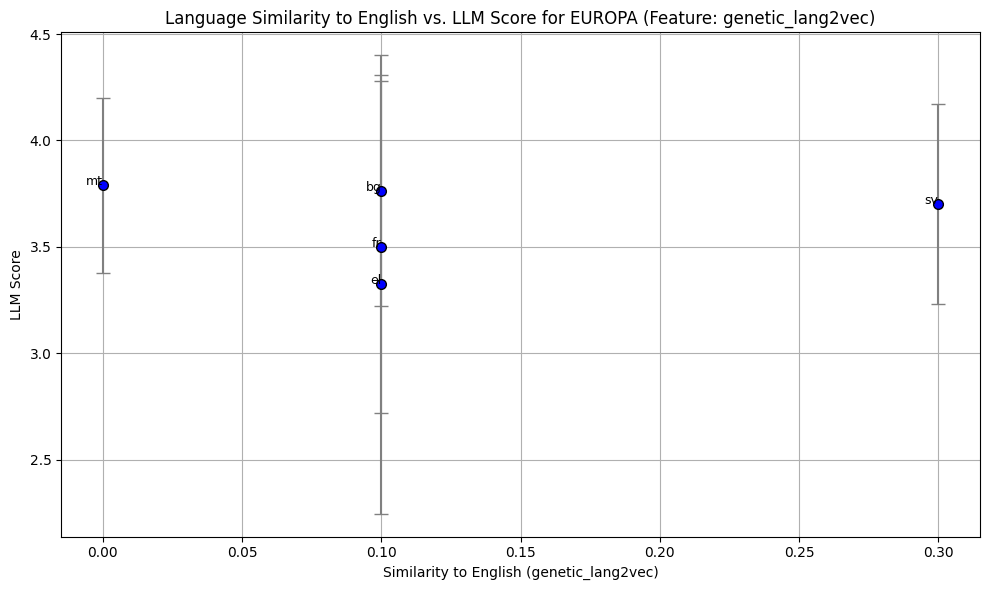

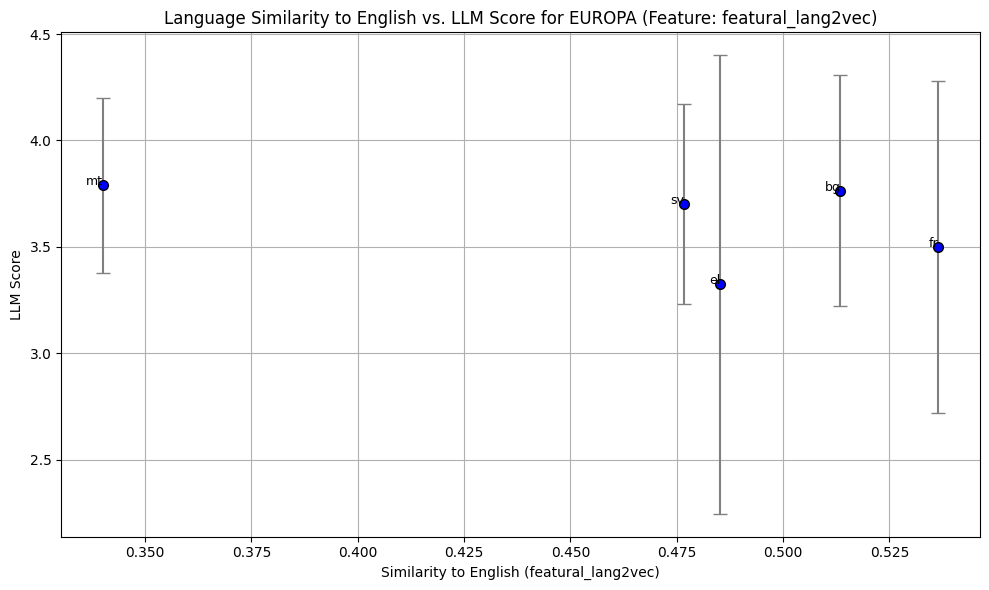

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ISO 639-1 to ISO 639-3 mapping for EUROPA languages
iso2_to_iso3 = {
    'en': 'eng', 'el': 'ell', 'bg': 'bul', 'mt': 'mlt',
    'fr': 'fra', 'sv': 'swe'
}

# Load LLM evaluation scores
scores_df = pd.read_csv("../europa_random_split/analysis/analysis_20250504_181917.txt", sep="\t")
scores_df = scores_df.rename(columns={'Language': 'language'})
scores_df['iso3'] = scores_df['language'].map(iso2_to_iso3)

# Option A (False): Use generated similarity files which use cosine similarity
# Option B (True): Use precomputed distance CSVs from Lang2Vec GitHub (need to download the file from 
# the repository: https://github.com/antonisa/lang2vec, unzip it and add it in Pipeline/data/language_similarity/lang2vec)
use_precomputed = True

if use_precomputed:
    distance_files = {
        'syntax_lang2vec': '../../data/language_similarity/lang2vec/distances/SYNTACTIC.csv',
        'phonology_lang2vec': '../../data/language_similarity/lang2vec/distances/PHONOLOGICAL.csv',
        'inventory_lang2vec': '../../data/language_similarity/lang2vec/distances/INVENTORY.csv',
        'geographic_lang2vec': '../../data/language_similarity/lang2vec/distances/GEOGRAPHIC.csv',
        'genetic_lang2vec': '../../data/language_similarity/lang2vec/distances/GENETIC.csv',
        'featural_lang2vec': '../../data/language_similarity/lang2vec/distances/FEATURAL.csv',
    }
else:
    distance_files = {
        'syntax_average': '../../data/language_similarity/lang2vec/syntax_average/language_similarity.csv',
        'phonology_average': '../../data/language_similarity/lang2vec/phonology_average/language_similarity.csv',
    }

# Plot for each distance feature
for feature, file_path in distance_files.items():

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    if use_precomputed:
        df_wide = pd.read_csv(file_path)
        df_wide = df_wide.rename(columns={df_wide.columns[0]: 'lang1'})
        df_long = df_wide.melt(id_vars='lang1', var_name='lang2', value_name='distance')
        eng_df = df_long[(df_long['lang1'] == 'eng') & (df_long['lang2'] != 'eng')].copy()
        eng_df['similarity'] = 1.0 - eng_df['distance']
        eng_df['iso3'] = eng_df['lang2']
    else:
        df = pd.read_csv(file_path)
        df = df.rename(columns={'language_1': 'lang1', 'language_2': 'lang2'})
        eng_df = df[
            ((df['lang1'] == 'eng') & (df['lang2'] != 'eng')) |
            ((df['lang2'] == 'eng') & (df['lang1'] != 'eng'))
            ].copy()
        eng_df['iso3'] = eng_df.apply(
            lambda row: row['lang2'] if row['lang1'] == 'eng' else row['lang1'],
            axis=1
        )
        eng_df['similarity'] = eng_df['similarity']

    # Merge and plot
    merged_df = eng_df.merge(scores_df, on='iso3')

    plt.figure(figsize=(10, 6))
    plt.errorbar(
        merged_df['similarity'],
        merged_df['Mean Score'],
        yerr=merged_df['Variance'],
        fmt='o',
        ecolor='gray',
        capsize=5,
        markerfacecolor='blue',
        markeredgecolor='black',
        markersize=7
    )

    for _, row in merged_df.iterrows():
        plt.text(row['similarity'], row['Mean Score'], row['language'], fontsize=9, ha='right')

    plt.xlabel(f"Similarity to English ({feature})")
    plt.ylabel("LLM Score")
    plt.title(f"Language Similarity to English vs. LLM Score for EUROPA (Feature: {feature})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
